# Génération d'images en Deep Learning

### Generative Adversarial Networks

#### Qu'est-ce qu'un GAN?

Les GAN sont une technique d'apprentissage profond permettant de saisir la distribution des données de formation afin de pouvoir générer de nouvelles données à partir de ces mêmes données.

Ils ont été inventés par **Ian Goodfellow** en 2014 et premièrement décrit dans l'article "[Generative Adversarial
Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)".

Ils sont constitués de deux modèles distincts, un *générateur* et un *discriminateur*. 
Le rôle du générateur est de produire de "fausses" images qui ressemblent aux images d'entraînement. Le travail du discriminateur consiste à regarder une image et dire s'il s'agit ou non d'une véritable image d'entraînement ou d'une fausse image du générateur.

Pendant l'entraînement, le générateur essaie constamment de déjouer le discriminateur en générant des images de plus en plus précises, tandis que le discriminateur s'efforce de devenir un meilleur détective et de classer correctement les images réelles et les images truquées. L'équilibre de ce jeu est atteint lorsque le générateur génère des contrefaçons parfaites qui semblent provenir directement des données d'entraînement, et que le discriminateur doit toujours deviner avec un niveau de confiance de 50 % que la sortie du générateur est réelle ou fausse.

Maintenant, définissons quelques notations à utiliser en commençant avec le discriminateur. 
Soit $x$ les données représentant une image. $D(x)$ est le réseau du discriminateur qui produit la probabilité que $x$ proviennent des données d'entraînement plutôt que du générateur. 
Ici, puisqu'il s'agit d'images, l'entrée dans $D(x)$ est une image de CHW (Channel Height Width) de taille 3x64x64. Intuitivement, $D(x)$ devrait être HAUT lorsque $x$ provient des données d'entraînement et BAS lorsque $x$ provient du générateur. On peut aussi penser à $D(x)$ comme un classificateur binaire traditionnel.

Pour la notation du générateur, soit $z$ un vecteur spatial latent échantillonné à partir d'une distribution normale standard. $G(z)$ représente la fonction génératrice qui met en correspondance le vecteur latent $z$ avec l'espace de données. 
Le but de $G$ est d'estimer la distribution d'où proviennent les données d'entraînement ($p_{data}$) afin de pouvoir générer de faux échantillons à partir de cette distribution estimée ($p_g$). 

Ainsi, $D(G(z))$ est la probabilité (scalaire) que la sortie du générateur $G$ soit une image réelle. Comme décrit dans l'article de [Goodfellow](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), $D$ et $G$ jouent un jeu minimax dans lequel $D$ essaie de maximiser la probabilité qu'il classe correctement les vrais et les faux ($logD(x)$), et $G$ essaie de minimiser la probabilité que $D$ prévoie que ses sorties sont fausses ($log(1-D(G(x)))$). 
D'après l'article, la fonction de perte du GAN est 

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

En théorie, la solution à ce jeu de minimax est où $p_g = p_{data}$, et le discriminateur devine au hasard si les entrées sont réelles ou fausses. Cependant, la théorie de la convergence des GAN fait toujours l'objet de recherches actives et, en réalité, les modèles ne s'entraînent pas toujours jusqu'à ce point.

#### Qu'est-ce qu'un DCGAN?

Un *DCGAN* est une extension directe du GAN décrit ci-dessus, sauf qu'il utilise explicitement des couches convolutionnelles et convolutionnelles-transposées dans le discriminateur et le générateur, respectivement. Il a été décrit pour la première fois par **Radford et. al.** dans l'article "[Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf)".

Le discriminateur est composé de couches de [convolution stridée](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d), de couches de [batch norm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) et d'activations [LeakyReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU). 
L'entrée est une image de 3x64x64 et la sortie est une probabilité scalaire que l'entrée soit issue de la distribution réelle des données.

Le générateur est composé de couches [convolutionnelles-transposées](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d), de couches de [batch norm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) et d'activations [ReLU](https://pytorch.org/docs/stable/nn.html#relu). 
L'entrée est un vecteur latent, $z$, qui est tiré d'une distribution normale standard et la sortie est une image RGB 3x64x64. Les couches conv-transposées permettent de transformer le vecteur latent en un volume ayant la même forme qu'une image. Dans l'article, les auteurs donnent également quelques conseils sur la façon de configurer les optimiseurs, de calculer les fonctions de perte et d'initialiser les poids du modèle, qui seront tous expliqués dans les sections suivantes.




In [1]:
from __future__ import print_function
%matplotlib inline

import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  5939


### Entrées

-  **dataroot** - le chemin d'accès à la racine du dossier de l'ensemble de données.
-  **workers** - le nombre de threads pour le chargement des données avec le DataLoader
-  **batch_size** - le batch size utilisé pour l'entraînement. Le papier DCGAN utilise une taille de lot de 128
-  **image_size** - la taille des images utilisées pour l'entraînement. Cette implémentation est par défaut en 64x64. Si une autre taille est souhaitée, les structures de D et G doivent être modifiées
-  **nc** - nombre de canaux de couleur des images d'entrée. Pour les images en couleur, ce nombre est de 3
-  **nz** - longueur du vecteur latent
-  **ngf** - se rapporte à la profondeur des feature maps propagées par le générateur
-  **ndf** - se rapporte à la profondeur des feature maps propagées par le discriminateur
-  **num_epochs** - nombre d'époques d'entraînement.
-  **lr** - taux d'apprentissage pour l'entraînement. Comme décrit dans l'article du DCGAN, ce nombre devrait être de 0,0002
-  **beta1** - hyperparamètre bêta1 pour les optimiseurs d'Adam. Comme décrit dans l'article, ce nombre devrait être de 0,5
-  **ngpu** - nombre de GPU disponibles. Si ce nombre est égal à 0, le code fonctionnera en mode CPU. Si ce nombre est supérieur à 0, il fonctionnera sur ce nombre de GPU




In [2]:
# Root directory for dataset
dataroot = "data/dcgan/training/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Données

Les données de terrains utilisées ont été traîtées. Chacune de ces images fait une taille de base de 600x600 pixels. Les images inutiles tels que les océans ont été supprimés afin d'obtenir de meilleurs résultats.




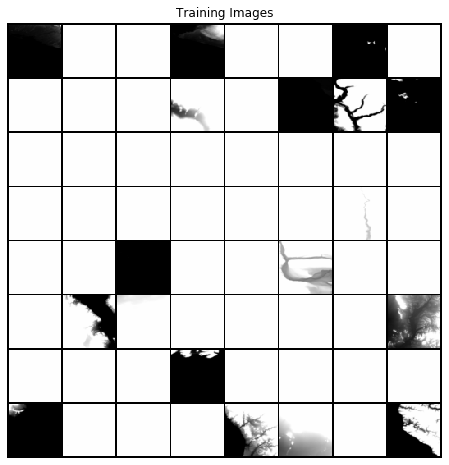

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Implémentation

Une fois les paramètres d'entrée définis et l'ensemble de données préparé, nous pouvons maintenant passer à la mise en œuvre. Nous commencerons par la stratégie d'initialisation du poids, puis nous parlerons en détail du générateur, du discriminateur, des fonctions de perte et de la boucle d'entraînement.

#### Initialisation du poids

Dans l'article de DCGAN, les auteurs précisent que tous les poids des modèles doivent être initialisés de manière aléatoire à partir d'une distribution normale avec *mean = 0*, *stdev = 0,02*. La fonction *weights_init* prend un modèle initialisé comme entrée et réinitialise toutes les couches de normalisation convolutives, convolutives-transposées et par lots pour répondre à ce critère. Cette fonction est appliquée aux modèles immédiatement après l'initialisation.

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#### Générateur

Le générateur, $G$, est conçu pour reproduire le vecteur spatial latent ($z$) à l'espace de données. Comme nos données sont des images, la conversion $z$ à l'espace de données signifie en fin de compte la création d'une image RGB avec le même taille que les images d'entraînement (c'est-à-dire 3x64x64). En pratique, cela se fait par une série de couches de transposition convolutionnelle bidimensionnelle, chacune étant associée à une couche 2d batch norm et à une activation ReLu.
La sortie du générateur est alimentée par une fonction *tanh* pour la ramener dans la plage de données d'entrée de $[-1,1]$.



In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Maintenant, nous pouvons instancier le générateur et appliquer la fonction *weights_init*.



In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


#### Discriminateur

Comme mentionné, le discriminateur, $D$, est une classification binaire qui prend une image comme entrée et produit une probabilité scalaire que l'image d'entrée est réelle (par opposition à une fausse). Ici, $D$ prend une image d'entrée de *3x64x64*, la traite par une série de Conv2d, BatchNorm2d, et les couches LeakyReLU, et produit la probabilité finale grâce à une fonction d'activation Sigmoïd. Cette architecture peut être étendue avec plus de couches si nécessaire pour le problème, mais il y a une signification à l'utilisation des Conv2D, des BatchNorm et des LeakyReLUs comme mentionné dans l'article du DCGAN.

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Maintenant, comme pour le générateur, nous pouvons créer le discriminateur, appliquer la fonction *weights_init* et imprimer la structure du modèle.

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


#### Fonctions de perte et optimiseurs

Avec la configuration $D$ et $G$, nous pouvons spécifier comment ils apprennent grâce aux fonctions de perte et aux optimiseurs. Nous utiliserons la fonction de perte "Binary Cross Entropy" ([BCELoss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)).

Ensuite, nous définissons notre vrai label comme 1 et le faux label comme 0. Ces labels seront utilisées pour calculer les pertes de $D$ et $G$, et c'est également la convention utilisée dans le document original du GAN. Enfin, nous avons mis en place deux optimiseurs distincts, l'un pour $D$ et l'autre pour $G$. 
Comme indiqué dans le document DCGAN, les deux sont des optimiseurs *Adam* avec un taux d'apprentissage de *0,0002* et *Beta1 = 0,5*. Pour suivre la progression de l'apprentissage du générateur, nous allons générer un lot fixe de vecteurs latents qui sont tirés d'une distribution gaussienne (i.e. fixed_noise). Dans la boucle de formation, nous introduirons périodiquement ce bruit_fixe en $G$, et au fil des itérations nous verrons les images se former à partir du bruit.



In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

#### Entraînement

Enfin, maintenant que nous avons défini toutes les parties du GAN, nous pouvons l'entraîner. Il ne faut pas oublier que l'entraînement des GAN est très sensible car un mauvais réglage des hyperparamètres entraîne l'effondrement du mode avec peu d'explications sur ce qui a mal tourné.
Ici, nous allons suivre de près l'algorithme 1 de l'article de Goodfellow, tout en respectant certaines des meilleures pratiques présentées dans [ganhacks](https://github.com/soumith/ganhacks).

**Part 1 - Entraîner le Discriminateur**

Rappelons que l'objectif de la formation du discriminateur est de maximiser la probabilité de classer correctement une entrée donnée comme réelle ou fausse. Selon les termes de Goodfellow, nous souhaitons "mettre à jour le discriminateur en faisant monter son gradient stochastique". Concrètement, nous voulons maximiser $log(D(x)) + log(1-D(G(z)))$.

**Part 2 - Entraîner le Générateur**

Comme indiqué dans le document original, nous voulons former le Générateur en minimisant $log(1-D(G(z)))$ dans un effort pour générer de meilleurs faux. Comme mentionné, Goodfellow a montré que cela ne permettait pas d'obtenir des gradients suffisants, en particulier au début du processus d'apprentissage. Comme solution, nous souhaitons plutôt maximiser $log(D(G(z)))$.

Enfin, nous ferons des rapports statistiques et à la fin de chaque époque, nous ferons passer notre lot de fixed_noise dans le générateur pour suivre visuellement la progression de l'entraînement de G. Les statistiques d'entraînement rapportées sont:

-  **Loss_D** - perte du discriminateur calculée avec la somme des pertes pour tous les batch réels et tous les batch factices ($log(D(x)) + log(D(G(z)))$).
-  **Loss_G** - perte du générateur calculée par $log(D(G(z)))$
-  **D(x)** - la production moyenne (sur l'ensemble du batch) du discriminateur pour le batch réel. Elle devrait commencer près de 1 puis théoriquement converger vers 0,5 lorsque G s'améliore.
-  **D(G(z))** - les sorties moyennes du discriminateur pour les batch de faux. Le premier numéro est avant la mise à jour de D et le second est après. Ces nombres devraient commencer près de 0 et converger vers 0,5 à mesure que G s'améliore.

Il est aussi possible de charger des modèles existants déjà entraînés:

In [ ]:
netG.load_state_dict(torch.load('models/generator.pt'))
netD.load_state_dict(torch.load('models/discriminator.pt'))

In [10]:
# Training Loop

# Lists to keep track of progress
img_list = []
imgs_generated = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            if ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                for i in fake:
                    imgs_generated.append(i)
        iters += 1

Starting Training Loop...
[1/200][0/26]	Loss_D: 1.7952	Loss_G: 1.9958	D(x): 0.3106	D(G(z)): 0.2380 / 0.1748
[2/200][0/26]	Loss_D: 0.1118	Loss_G: 11.6098	D(x): 0.9248	D(G(z)): 0.0010 / 0.0000
[3/200][0/26]	Loss_D: 0.0122	Loss_G: 33.7467	D(x): 0.9880	D(G(z)): 0.0000 / 0.0000
[4/200][0/26]	Loss_D: 0.0000	Loss_G: 27.8240	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[5/200][0/26]	Loss_D: 0.0001	Loss_G: 15.8065	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[6/200][0/26]	Loss_D: 0.0023	Loss_G: 8.7344	D(x): 0.9995	D(G(z)): 0.0018 / 0.0002
[7/200][0/26]	Loss_D: 0.0132	Loss_G: 8.9599	D(x): 0.9996	D(G(z)): 0.0127 / 0.0002
[8/200][0/26]	Loss_D: 0.6917	Loss_G: 30.2730	D(x): 0.6341	D(G(z)): 0.1532 / 0.0000
[9/200][0/26]	Loss_D: 0.0006	Loss_G: 36.9823	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[10/200][0/26]	Loss_D: 0.0001	Loss_G: 36.9103	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[11/200][0/26]	Loss_D: 0.0000	Loss_G: 36.8299	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[12/200][0/26]	Loss_D: 0.0000	Loss_G: 36.7051	D(x): 1.0000	D(G

[100/200][0/26]	Loss_D: 1.2034	Loss_G: 4.8925	D(x): 0.6915	D(G(z)): 0.1944 / 0.0105
[101/200][0/26]	Loss_D: 0.5173	Loss_G: 3.7403	D(x): 0.9175	D(G(z)): 0.3330 / 0.0514
[102/200][0/26]	Loss_D: 0.1131	Loss_G: 3.0961	D(x): 0.9982	D(G(z)): 0.0990 / 0.0578
[103/200][0/26]	Loss_D: 0.4490	Loss_G: 5.2237	D(x): 0.9982	D(G(z)): 0.3412 / 0.0061
[104/200][0/26]	Loss_D: 0.0540	Loss_G: 7.1347	D(x): 0.9961	D(G(z)): 0.0347 / 0.0031
[105/200][0/26]	Loss_D: 0.3113	Loss_G: 3.1883	D(x): 0.9676	D(G(z)): 0.2282 / 0.0494
[106/200][0/26]	Loss_D: 0.5065	Loss_G: 2.6299	D(x): 0.8964	D(G(z)): 0.2922 / 0.0857
[107/200][0/26]	Loss_D: 0.0437	Loss_G: 4.3989	D(x): 0.9789	D(G(z)): 0.0219 / 0.0151
[108/200][0/26]	Loss_D: 0.2678	Loss_G: 3.0228	D(x): 0.9742	D(G(z)): 0.1578 / 0.0657
[109/200][0/26]	Loss_D: 0.0551	Loss_G: 4.3944	D(x): 0.9567	D(G(z)): 0.0101 / 0.0148
[110/200][0/26]	Loss_D: 0.3328	Loss_G: 3.8848	D(x): 0.7278	D(G(z)): 0.0055 / 0.0257
[111/200][0/26]	Loss_D: 0.1624	Loss_G: 3.8732	D(x): 0.9809	D(G(z)): 0.0848 /

[198/200][0/26]	Loss_D: 0.2949	Loss_G: 2.6473	D(x): 0.8643	D(G(z)): 0.1342 / 0.0904
[199/200][0/26]	Loss_D: 0.7832	Loss_G: 1.1314	D(x): 0.7280	D(G(z)): 0.3290 / 0.3757
[200/200][0/26]	Loss_D: 1.0327	Loss_G: 3.7187	D(x): 0.8611	D(G(z)): 0.5501 / 0.0342


#### Sauvegarde de l'état du générateur et du discriminateur

In [11]:
torch.save(netG.state_dict(), "models/generator2.pt")
torch.save(netD.state_dict(), "models/discriminator2.pt")

### Résultats

Ici, nous allons examiner trois résultats différents. Tout d'abord, nous verrons comment les pertes de $D$ et $G$ ont changé pendant la formation. Ensuite, nous visualiserons la sortie de G sur le lot fixed_noise pour chaque époque. Et troisièmement, nous examinerons un lot de données réelles à côté d'un lot de données fictives de G.

**Graphique des pertes de D & G par rapport aux itérations de formation.**

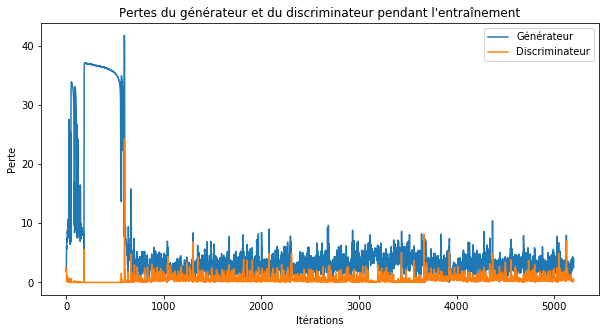

In [12]:
plt.figure(figsize=(10,5))
plt.title("Pertes du générateur et du discriminateur pendant l'entraînement")
plt.plot(G_losses,label="Générateur")
plt.plot(D_losses,label="Discriminateur")
plt.xlabel("Itérations")
plt.ylabel("Perte")
plt.legend()
plt.savefig('data/dcgan/latest.png')
plt.show()

**Visualisation de la progression du Générateur**

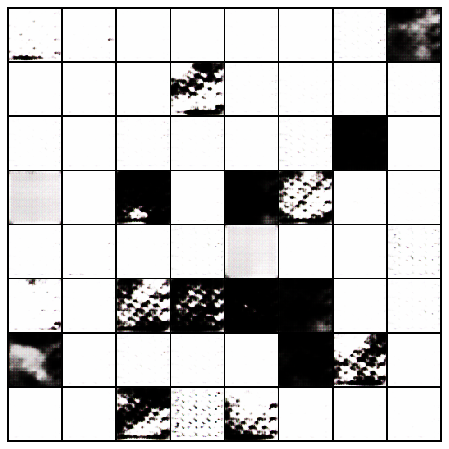

In [13]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Kr4unos'), bitrate=1800)

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('data/dcgan/latest.mp4', writer=writer)

HTML(ani.to_jshtml())

**Vraies images vs images générées**

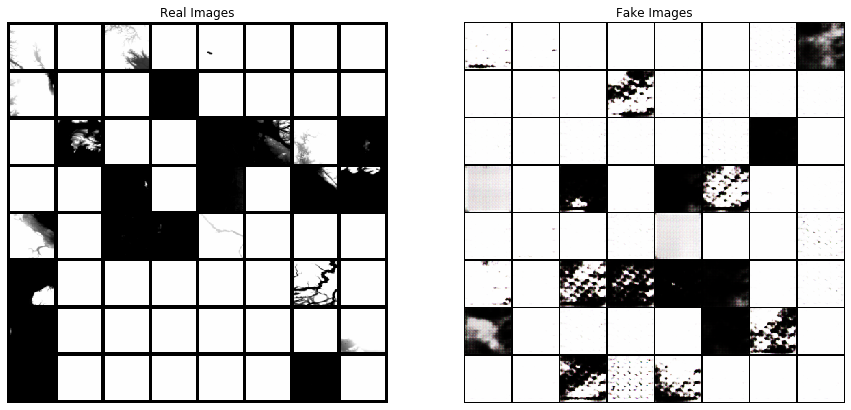

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

#### Enregistrement des images générées

In [ ]:
i = 0
for img in imgs_generated:
    vutils.save_image(img, 'data/dcgan/generated/output_' + str(i) + '.tif')
    i += 1